# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [ ]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    """
    global old_Lx1, old_Lx2, old_Rx1, old_Rx2
    y_max = img.shape[0]
    y_min = int(0.6*img.shape[0])
    left_slope = []
    right_slope = []
    left_y_cept = []
    right_y_cept = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            y_cept = y1 - m*x1
            if m < -0.3 and m > -4:                 #count negative slopes as left marker
                left_slope.append(m)
            elif m > 0.3 and m < 4:                 #count positive slopes as right marker
                right_slope.append(m)
            if y_cept > y_max:                      #left lane marker must have y-intercept> frame height
                left_y_cept.append(y_cept)
            elif y_cept < 0.5*y_max:                #right lane marker must have y-intercept< 0.5* frame ht
                right_y_cept.append(y_cept)
        
    #Averaging slopes and intercepts
    l_slopeMean = np.mean(left_slope)
    r_slopeMean = np.mean(right_slope)
    l_yceptMean = np.mean(left_y_cept)
    r_yceptMean = np.mean(right_y_cept)
    
    if abs(l_slopeMean)>0.4:                            # only keep lines steeper than 22deg & exclude slopeMean=0
        try:
            Lx1 = int(old_Lx1*0.8 + 0.2*((y_max - l_yceptMean)/l_slopeMean))  #reduce jitter in lines for video
        except: 
            Lx1 = int((y_max - l_yceptMean)/l_slopeMean)
        try:
            Lx2 = int(old_Lx2*0.8 + 0.2*((y_min - l_yceptMean)/l_slopeMean))
        except:
            Lx2 = int((y_min - l_yceptMean)/l_slopeMean)
        #cv2.line(img, (Lx1, y_max), (Lx2, y_min), color, thickness)
                
    if abs(r_slopeMean)>0.4:
        try:
            Rx1 = int(old_Rx1*0.8 + 0.2*((y_max - r_yceptMean)/r_slopeMean))
        except:
            Rx1 = int((y_max - r_yceptMean)/r_slopeMean)
        try:
            Rx2 = int(old_Rx2*0.8 + 0.2*((y_min - r_yceptMean)/r_slopeMean))
        except:
            Rx2 = int((y_min - r_yceptMean)/r_slopeMean)  
            
    cv2.line(img, (Rx1, y_max), (Rx2, y_min), color, thickness)
    cv2.line(img, (Lx1, y_max), (Lx2, y_min), color, thickness)
    
    old_Lx1 = Lx1                                    #for video smoothing
    old_Lx2 = Lx2
    old_Rx1 = Rx1
    old_Rx2 = Rx2

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

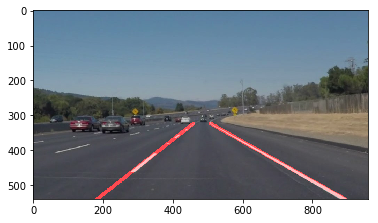

In [4]:
# TODO: Build your pipeline that will draw lane lines on the test_images
#reading in an image
old_Lx1 = None
old_Lx2 = None
old_Rx1 = None
old_Rx2 = None
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

gray = grayscale(image)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 7
blur_gray = gaussian_blur(gray,kernel_size)

# Define parameters for Canny and apply
low_threshold = 50
high_threshold = 100
edges = canny(blur_gray, low_threshold, high_threshold)


# Next we'll create a masked edges image using cv2.fillPoly()

imshape = image.shape
vertices = np.array([[(75,imshape[0]),(0.45*imshape[1], 0.6*imshape[0]), (0.55*imshape[1], 0.6*imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)

masked_edges = region_of_interest(edges, vertices)


# Define the Hough transform parameters

rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 80     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100 #minimum number of pixels making up a line
max_line_gap = 200    # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
hough_out = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

# Draw the lines on the image
lines_edges = weighted_img(hough_out, image) 
plt.imshow(lines_edges)
#plt.savefig('Fig1out.jpg', dpi=150)



## Results & Output
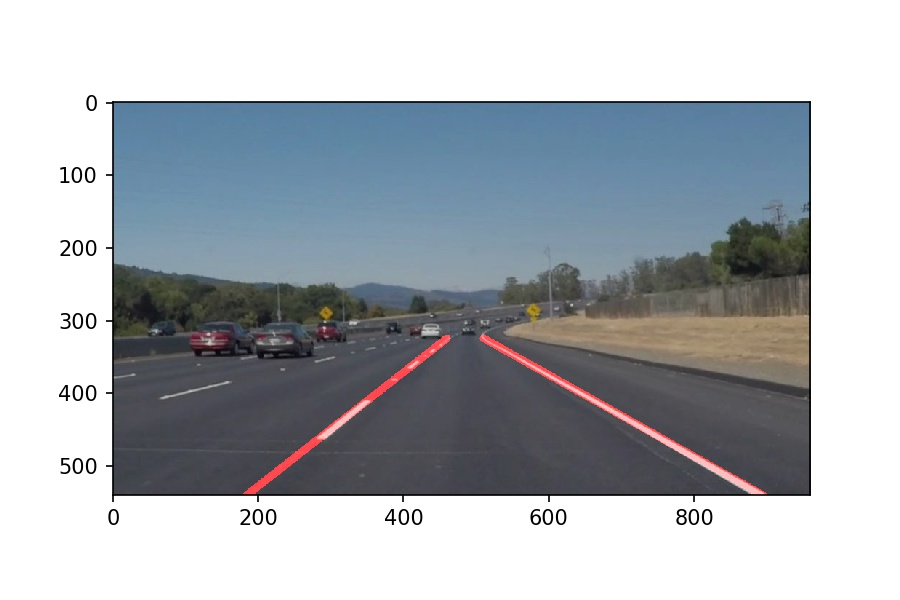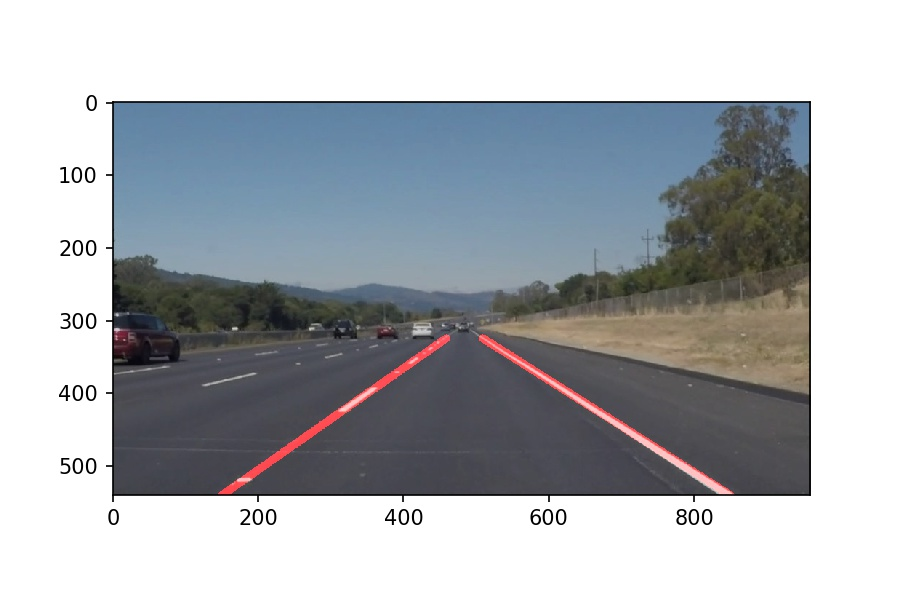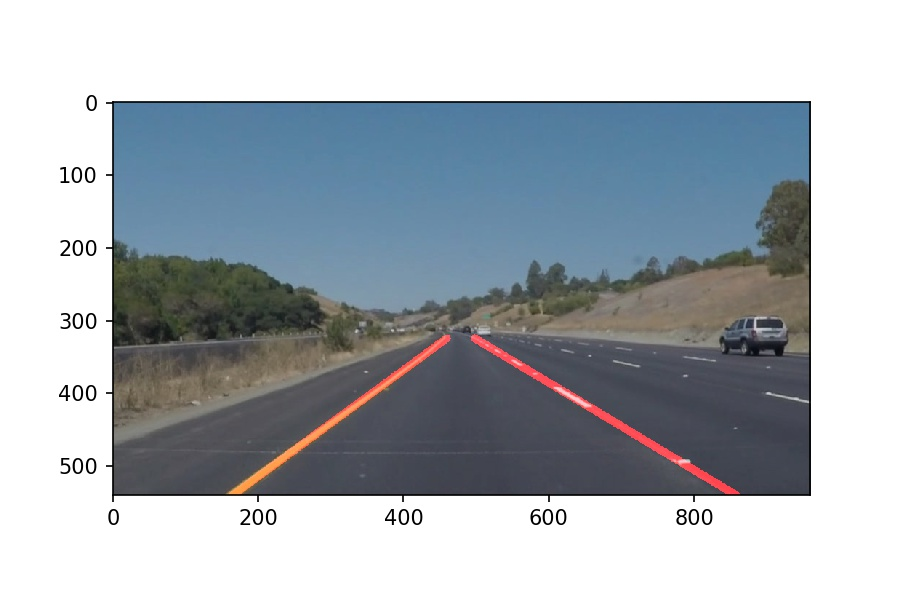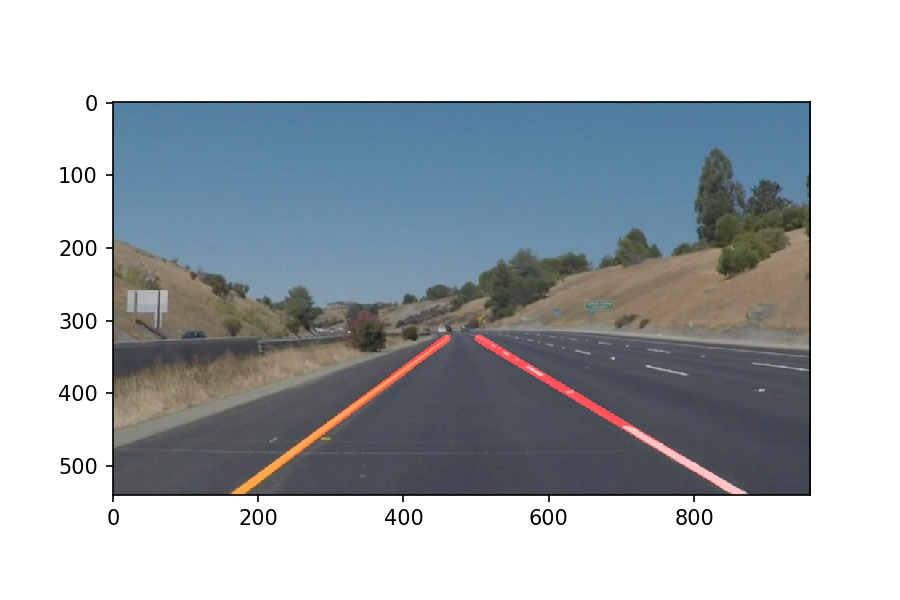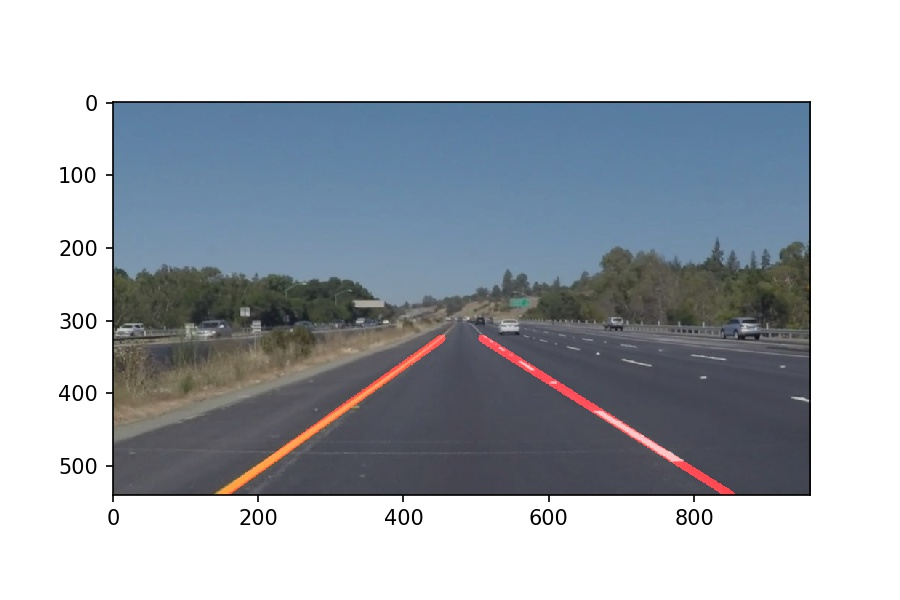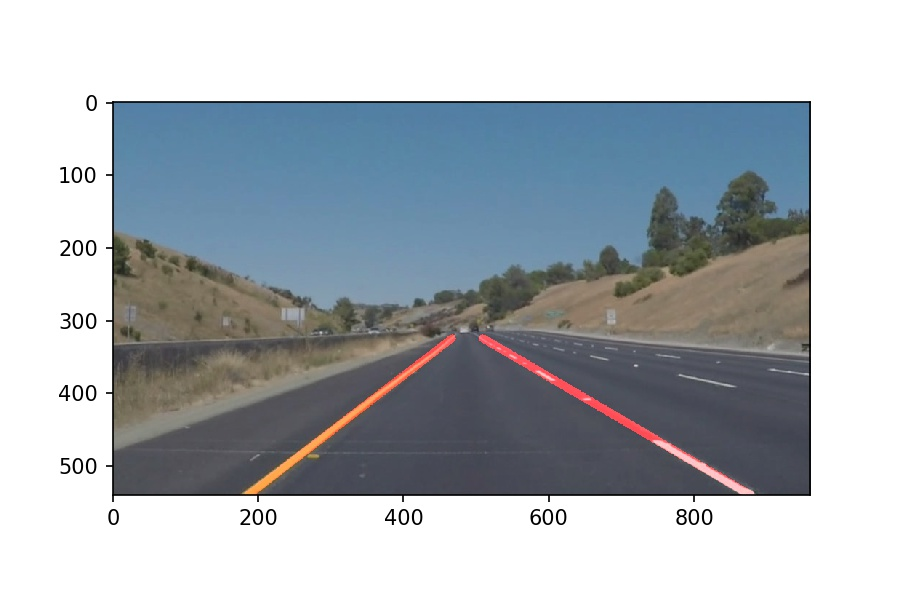


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    
    #gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 7
    blur_gray = gaussian_blur(image,kernel_size)

    # Define parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    imshape = image.shape
    vertices = np.array([[(75,imshape[0]),(0.45*imshape[1], 0.6*imshape[0]), (0.55*imshape[1], 0.6*imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 80 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
    # Run Hough on edge detected image
    hough_out = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the image
    lines_edges = weighted_img(hough_out, image)

    return lines_edges

Let's try the one with the solid white lane on the right first ...

In [7]:
old_Lx1 = None
old_Lx2 = None
old_Rx1 = None
old_Rx2 = None
white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4", audio=False)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 58.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 4.11 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
old_Lx1 = None
old_Lx2 = None
old_Rx1 = None
old_Rx2 = None
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4', audio=False)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:11<00:00, 58.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 12 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

My image processing pipeline consisted of the following 6 steps: RGB --> Grayscale --> Canny Edge detection -->
Blurring --> Masking --> Hough transform --> Redrawing line on weighted original. All 6 resulting images are included above.
For the video part, however, I omitted the conversion to Grayscale part, as brightness levels (luminance?) on parts of the road in the Challenge video were similar to lane markings.
For the draw-lines() function, after picking up all lines in the region of interest, I selected the lines with a slope from -0.3 to -4 as Left lane markers, and lines with a slope of 0.3 to 4 as Right lane markers. This omits "flattish" lines with a slope ~0 and ~vertical lines. Lines with a y-intercept greater than image height were chosen as left markers, and those with y-intercept below 50% of image height were chosen as right lane markers. I averaged the slope and y-intercepts of the resulting left and right markers to create two lines extending from the bottom of the image to 60% of image height. (rather than hard numbers coded in, wherever possible, I tried to scale to image size here & in region-of-interest, to improve robustness to arbitrary image sizes.

### Potential Shortcomings of pipeline
1. Computationally intensive: for real-time processing, I felt my pipeline was rather slow; it needs to be more efficient.
2. Shadows, variation in lighting & road surface/ color: For the video processing I omitted the grayscale conversion as it was causing problems in the challenge video. A grayscale rendition would obviously help in computation efficiency.
3. Proximity of shoulder: If the shoulder is too close to the lane marking, my pipeline will be confused by the Canny edge created by that, and since I'm averaging lines, the drawn lines would be wider than appropriate.
4. Driving in traffic: Large bright vehicles/objects, both near and far will probably introduce artifacts, posing a problem for correct lane line identification.
5. Sharp curves: Wiggly roads and sharp curves will have issues since I'm doing a 1inear extrapolation.

### Improvements
I think filtering out a range of colors around the colors used for lane markings would help. Smoothing was a very big challenge for me, as frames where a lane marking was not detected first gave me NaN errors(!!!), and then bouncing lines. I had thought of averaging over 4-5 frames, but only belatedly figured out a way to do it! I "cheated" to see what others had done, and used a weighted sum of just 2 frames (current & previous).
Finally, I think my code needs to be able to handle errors more robustly. I suspect that if lane markings are washed out for a number of frames, the pipeline may crash. I plan to run this pipeline on more extreme/ fringe case situations.

### Follow-up to reviewer feed-back
My intention had been to use as similar parameters for the 6 images and for the video (for Hough, blur & Canny). In processing video I had hoped to use as much blur I could do in hopes of reducing computation load. Hence kernel_size up to 11, and rho of 4. I reduced both of these to 7 & 2 respectively in line with reviewer's suggestion.
I nudged up min_line_length to 80 from 40 previously, but left threshold at 50. I had discovered that I had to lower these parameters in order to eliminate NaN errors that I believe were coming from frames where there were no lines, and thus slopeMean would go to zero, resulting in divide by zero errors. As mentioned in the improvement section, I would have liked to make the code more resilient when faced with such math errors; this is the reason for the try/except lines for some of the calculations. PS: the shortcomings/improvements sections were already there in my submission; I've highlighted the label headings just to help.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
old_Lx1 = None
old_Lx2 = None
old_Rx1 = None
old_Rx2 = None
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4', audio=False)
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:08<00:00, 31.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 8.66 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))